In [1]:
import re, pickle
from datetime import datetime, timedelta
import GPy
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from IPython.display import display
from mapsplotlib import mapsplot as mplt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Load data

In [3]:
df = pd.read_excel("DTU - data til case_LTMZones2.xlsx")
df.head()

,TurID,BilID,PersonID,Latitude (Start),Longitude (Start),Latitude (Slut),Longitude (Slut),Reservationstidspunkt,Start tidspunkt,Slut tidspunkt,Alder,Køn,Batteristatus (start),Batteristatus (slut),Km kørt,FromZoneID,ToZoneID
0,1,WBY1Z21040V307905,32614,55.6703,12.5861,55.653,12.5447,2017-08-16 14:40:29,2017-08-16 14:34:29,2017-08-16 14:52:55,32,M,94,91,5,103142,102851
1,2,WBY1Z21040V308214,44363,55.687,12.586,55.7267,12.5539,2017-08-16 14:42:00,2017-08-16 14:38:00,2017-08-16 15:05:22,25,M,48,42,7,102212,157231
2,3,WBY1Z21070V307929,38610,55.6924,12.5831,55.7757,12.514,2017-07-31 07:28:38,2017-07-31 07:21:38,2017-08-01 12:49:44,21,M,0,0,19,102213,173051
3,4,WBY1Z21040V307869,37425,55.6303,12.6489,55.7069,12.5871,2017-07-31 20:31:07,2017-07-31 20:31:07,2017-08-01 09:13:25,30,M,0,0,18,185203,102341
4,5,WBY1Z21030V307877,24168,55.6936,12.5382,55.6775,12.4892,2017-07-31 20:48:30,2017-07-31 20:44:30,2017-08-01 08:52:43,28,M,0,0,5,102454,102771


In [4]:
# convert dates to datetime format
df["Reservationstidspunkt"] = pd.to_datetime(df["Reservationstidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["Start tidspunkt"] = pd.to_datetime(df["Start tidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["Slut tidspunkt"] = pd.to_datetime(df["Slut tidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["date"] = df["Start tidspunkt"].dt.date

# Basic descriptive statistics

In [5]:
print("Total transactions:", len(df))
print("Total number of cars:", len(np.unique(df["BilID"])))
print("Number of unique customers:", len(np.unique(df["PersonID"])))
print("Period start:", df["date"].min())
print("Period end:", df["date"].max())

Total transactions: 366420
Total number of cars: 347
Number of unique customers: 25380
Period start: 2017-07-31
Period end: 2018-05-08


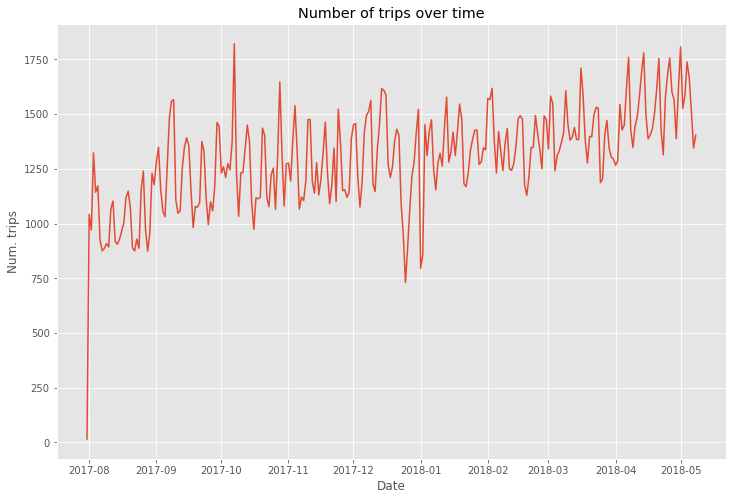

In [6]:
grouped = df.groupby("date")["TurID"].count()
plt.plot(grouped.index, grouped.values)
plt.xlabel("Date")
plt.ylabel("Num. trips")
plt.title("Number of trips over time")
plt.show()

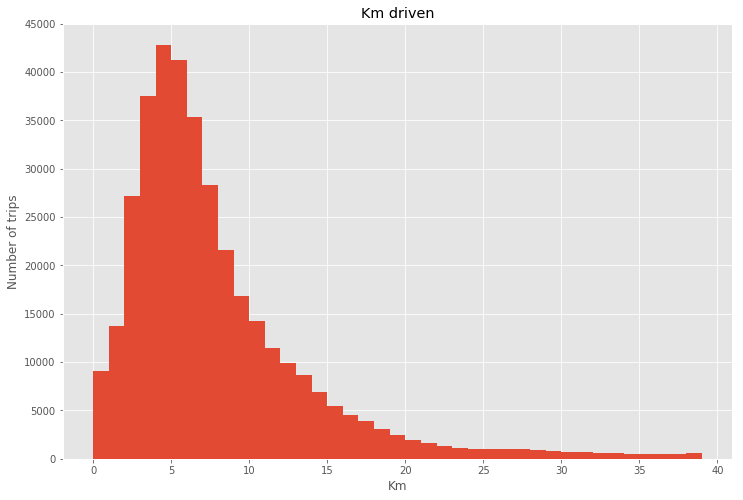

In [7]:
plt.hist(df["Km kørt"], bins=range(40))
plt.title("Km driven")
plt.xlabel("Km")
plt.ylabel("Number of trips")
plt.show()

# Process data and generate demand and supply

In [8]:
zone_ids = np.unique((df["FromZoneID"] / 10).astype(np.int)).tolist()
for z_id in np.unique((df["ToZoneID"] / 10).astype(np.int)).tolist():
    if z_id not in zone_ids:
        zone_ids.append(z_id)
vehicle_ids = np.unique(df["BilID"])

In [9]:
# sort trips by start time
df_sorted = df.sort_values("Start tidspunkt")

n = 0
start_date = datetime(2017, 8, 5) # ignore data before this datetime
current_time = 0
current_date = start_date.strftime("%Y-%m-%d %H:00")
dates_demand = {}
demand = {}
demand_temp = {z_id:0 for z_id in zone_ids}
for ix, row in df_sorted.iterrows():
    n += 1
    if not n % 10000:
        print("%d of %d rows processed for far..." % (n, len(df)))
    
    # ignore invalid rows
    if row["BilID"] == '-':
        continue
    try:
        start_lat = float(row["Latitude (Start)"])
        start_lng = float(row["Longitude (Start)"])
        end_lat = float(row["Latitude (Slut)"])
        end_lng = float(row["Longitude (Slut)"])
    except:
        continue
    
    # skip the first days so that we can figure out the positions of all cars
    if row["Start tidspunkt"] < start_date:
        continue
    
    # get current time bin (by hour)
    time = int((row["Start tidspunkt"] - start_date).total_seconds() / 60 / 60)
    
    if time != current_time: # if time bin (hour) has changed
        
        # save demand (note that this is the demand for the current time bin)
        dates_demand[current_time] = current_date
        demand[current_time] = demand_temp
        
        # reset variables
        demand_temp = {z_id:0 for z_id in zone_ids}
        current_time = time
        current_date = row["Start tidspunkt"].strftime("%Y-%m-%d %H:00")
        
    # get origin and destination zones
    origin_zone = int(int(row["FromZoneID"]) / 10)
    destination_zone = int(int(row["ToZoneID"]) / 10)
    
    # update demand for corresponding zone
    demand_temp[origin_zone] += 1

print("Done!")

10000 of 366420 rows processed for far...
20000 of 366420 rows processed for far...
30000 of 366420 rows processed for far...
40000 of 366420 rows processed for far...
50000 of 366420 rows processed for far...
60000 of 366420 rows processed for far...
70000 of 366420 rows processed for far...
80000 of 366420 rows processed for far...
90000 of 366420 rows processed for far...
100000 of 366420 rows processed for far...
110000 of 366420 rows processed for far...
120000 of 366420 rows processed for far...
130000 of 366420 rows processed for far...
140000 of 366420 rows processed for far...
150000 of 366420 rows processed for far...
160000 of 366420 rows processed for far...
170000 of 366420 rows processed for far...
180000 of 366420 rows processed for far...
190000 of 366420 rows processed for far...
200000 of 366420 rows processed for far...
210000 of 366420 rows processed for far...
220000 of 366420 rows processed for far...
230000 of 366420 rows processed for far...
240000 of 366420 row

In [10]:
# sort trips by end time
df_sorted = df.sort_values("Slut tidspunkt")

# keep track of all vehicles at every time step
vehicle_pos = {v_id:None for v_id in vehicle_ids}
vehicle_zone = {v_id:None for v_id in vehicle_ids}
n = 0
start_date = datetime(2017, 8, 5) # ignore data before this datetime
current_time = 0
current_date = start_date.strftime("%Y-%m-%d %H:00")
dates_supply = {}
supply = {}
for ix, row in df_sorted.iterrows():
    n += 1
    if not n % 10000:
        print("%d of %d rows processed for far..." % (n, len(df)))
    
    # ignore invalid rows
    if row["BilID"] == '-':
        continue
    try:
        start_lat = float(row["Latitude (Start)"])
        start_lng = float(row["Longitude (Start)"])
        end_lat = float(row["Latitude (Slut)"])
        end_lng = float(row["Longitude (Slut)"])
    except:
        continue
    
    # skip the first days so that we can figure out the positions of all cars
    if row["Start tidspunkt"] < start_date:
        # save vehicle position for tracking
        vehicle_pos[row["BilID"]] = (end_lat, end_lng)
        continue
    
    # get current time bin (by hour)
    time = int((row["Slut tidspunkt"] - start_date).total_seconds() / 60 / 60)
    
    if time != current_time: # if time bin (hour) has changed
        # compute supply
        supply_temp = {z_id:0 for z_id in zone_ids}
        for v_id in vehicle_zone:
            if vehicle_zone[v_id] != None:
                supply_temp[vehicle_zone[v_id]] += 1
        
        # save supply (note that this will be supply for the next bin!)
        dates_supply[current_time+1] = row["Slut tidspunkt"].strftime("%Y-%m-%d %H:00")
        supply[current_time+1] = supply_temp
        
        # reset variables
        current_time = time
        current_date = row["Slut tidspunkt"].strftime("%Y-%m-%d %H:00")
        
    # get origin and destination zones
    origin_zone = int(int(row["FromZoneID"]) / 10)
    destination_zone = int(int(row["ToZoneID"]) / 10)
    
    # update vehicle position and zone in tracking
    vehicle_pos[row["BilID"]] = (end_lat, end_lng)
    vehicle_zone[row["BilID"]] = destination_zone

print("Done!")

10000 of 366420 rows processed for far...
20000 of 366420 rows processed for far...
30000 of 366420 rows processed for far...
40000 of 366420 rows processed for far...
50000 of 366420 rows processed for far...
60000 of 366420 rows processed for far...
70000 of 366420 rows processed for far...
80000 of 366420 rows processed for far...
90000 of 366420 rows processed for far...
100000 of 366420 rows processed for far...
110000 of 366420 rows processed for far...
120000 of 366420 rows processed for far...
130000 of 366420 rows processed for far...
140000 of 366420 rows processed for far...
150000 of 366420 rows processed for far...
160000 of 366420 rows processed for far...
170000 of 366420 rows processed for far...
180000 of 366420 rows processed for far...
190000 of 366420 rows processed for far...
200000 of 366420 rows processed for far...
210000 of 366420 rows processed for far...
220000 of 366420 rows processed for far...
230000 of 366420 rows processed for far...
240000 of 366420 row

In [11]:
# check fraction of cases in which demand is greater than (or equal to) the supply
total_cases = 0
boundary_cases = 0
problem_cases = 0
missings = 0
for t in demand:
    for z_id in zone_ids:
        if t not in supply.keys():
            missings += 1
            continue
        if demand[t][z_id] == supply[t][z_id]:
            boundary_cases += 1
        elif demand[t][z_id] > supply[t][z_id]:
            problem_cases += 1
        total_cases += 1

print("Total cases:", total_cases)
print("Total missings:", missings)
print("Total boundary cases: %d (%.1f perc.)" % (boundary_cases, 100.0*boundary_cases/total_cases))
print("Total problematic cases: %d (%.1f perc.)" % (problem_cases, 100.0*problem_cases/total_cases))

Total cases: 1185875
Total missings: 1790
Total boundary cases: 649897 (54.8 perc.)
Total problematic cases: 10578 (0.9 perc.)


# Visualize data for an example zone

Fraction of boundary cases: 0.061
Fraction of problematic cases: 0.029


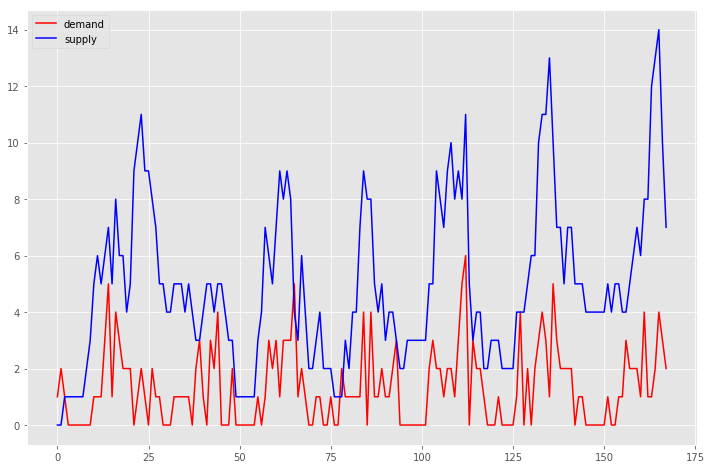

In [12]:
zone_id = 10222
demand_ts = [demand[t][zone_id] for t in demand if t in supply.keys()]
supply_ts = [supply[t][zone_id] for t in demand if t in supply.keys()]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.334
Fraction of problematic cases: 0.071


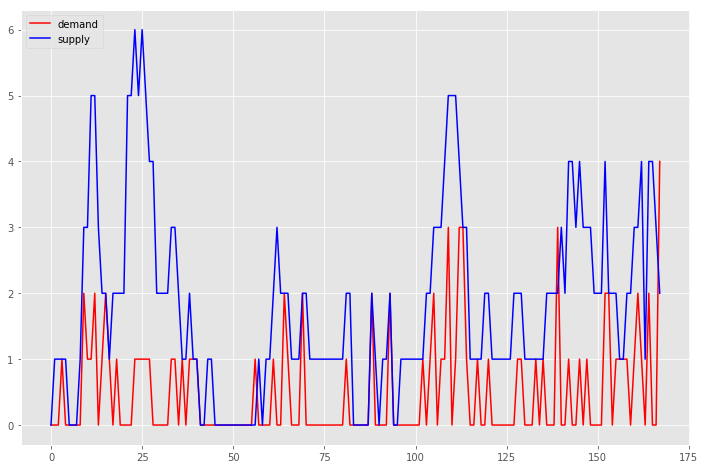

In [13]:
zone_id = 10212
demand_ts = [demand[t][zone_id] for t in demand if t in supply.keys()]
supply_ts = [supply[t][zone_id] for t in demand if t in supply.keys()]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.611
Fraction of problematic cases: 0.020


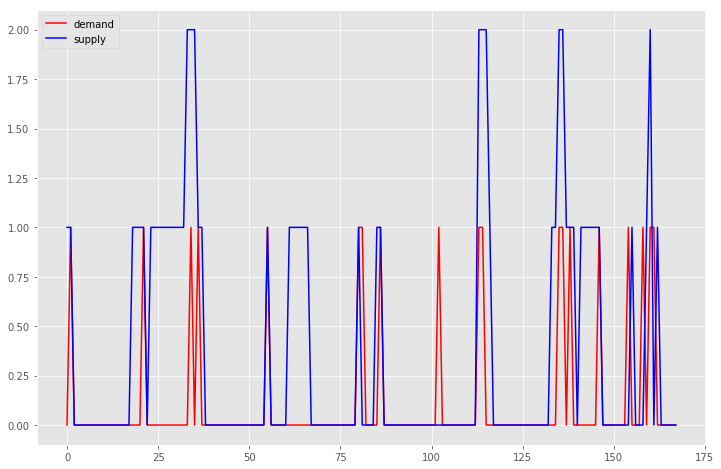

In [14]:
zone_id = 10211
demand_ts = [demand[t][zone_id] for t in demand if t in supply.keys()]
supply_ts = [supply[t][zone_id] for t in demand if t in supply.keys()]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.020
Fraction of problematic cases: 0.003


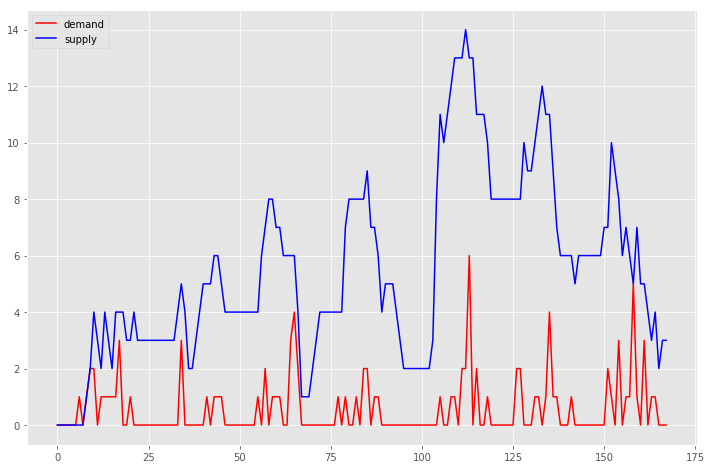

In [15]:
zone_id = 10233
demand_ts = [demand[t][zone_id] for t in demand if t in supply.keys()]
supply_ts = [supply[t][zone_id] for t in demand if t in supply.keys()]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.493
Fraction of problematic cases: 0.034


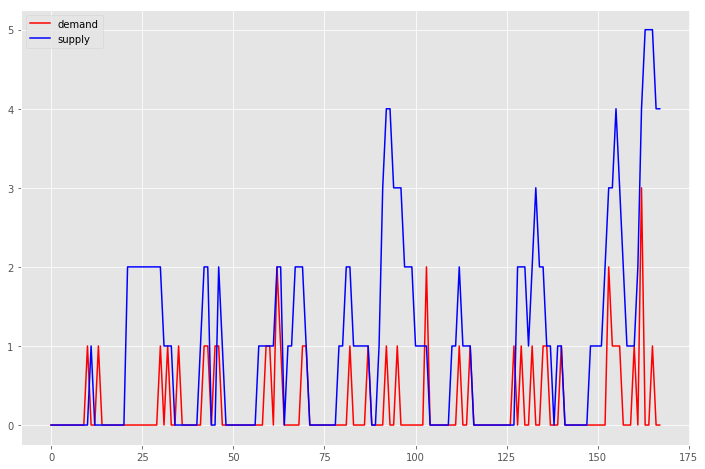

In [16]:
zone_id = 10223
demand_ts = [demand[t][zone_id] for t in demand if t in supply.keys()]
supply_ts = [supply[t][zone_id] for t in demand if t in supply.keys()]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

# Zones with most demand

In [17]:
for z_id in zone_ids:
    demand_ts = [demand[t][z_id] for t in demand if t in supply.keys()]
    mean_demand = np.mean(demand_ts)
    if mean_demand < 1.5:
        continue
    print("Zone: %d -> Avg. demand: %.1f" % (z_id, mean_demand))

Zone: 10222 -> Avg. demand: 1.7
Zone: 10234 -> Avg. demand: 1.9
Zone: 10244 -> Avg. demand: 2.1
Zone: 17304 -> Avg. demand: 1.6


NameError: name 'demand_ts' is not defined

# Save demand and supply data to disk

In [21]:
output_dir = "prepared/demand_supply"
dates_demand_rev = {v:k for k,v in dates_demand.items()}
dates_supply_rev = {v:k for k,v in dates_supply.items()}
for z_id in zone_ids:
    fw = open("%s/%d.csv" % (output_dir, z_id), "w")
    fw.write("time,demand,supply\n")
    current_time = start_date
    end_time = datetime(2018,5,1)
    added_zeros = 0
    count = 0
    while current_time < end_time:
        count += 1

        time_str = current_time.strftime("%Y-%m-%d %H:00")
        try:
            d = demand[dates_demand_rev[time_str]][z_id]
        except:
            added_zeros += 1
            d = 0
        try:
            s = supply[dates_supply_rev[time_str]][z_id]
        except:
            added_zeros += 1
            s = 0
        fw.write("%s,%d,%d\n" % (time_str,d,s))
        current_time += timedelta(hours=1)

    fw.close()
    print("Saved zone id %d. Count=%d, AddedZeros=%d" % (z_id, count, added_zeros))

Saved zone id 0. Count=6456, AddedZeros=24
Saved zone id 10211. Count=6456, AddedZeros=24
Saved zone id 10212. Count=6456, AddedZeros=24
Saved zone id 10213. Count=6456, AddedZeros=24
Saved zone id 10214. Count=6456, AddedZeros=24
Saved zone id 10215. Count=6456, AddedZeros=24
Saved zone id 10216. Count=6456, AddedZeros=24
Saved zone id 10217. Count=6456, AddedZeros=24
Saved zone id 10218. Count=6456, AddedZeros=24
Saved zone id 10221. Count=6456, AddedZeros=24
Saved zone id 10222. Count=6456, AddedZeros=24
Saved zone id 10223. Count=6456, AddedZeros=24
Saved zone id 10231. Count=6456, AddedZeros=24
Saved zone id 10232. Count=6456, AddedZeros=24
Saved zone id 10233. Count=6456, AddedZeros=24
Saved zone id 10234. Count=6456, AddedZeros=24
Saved zone id 10235. Count=6456, AddedZeros=24
Saved zone id 10241. Count=6456, AddedZeros=24
Saved zone id 10242. Count=6456, AddedZeros=24
Saved zone id 10243. Count=6456, AddedZeros=24
Saved zone id 10244. Count=6456, AddedZeros=24
Saved zone id 102

Saved zone id 25908. Count=6456, AddedZeros=24
Saved zone id 26525. Count=6456, AddedZeros=24
Saved zone id 37011. Count=6456, AddedZeros=24
Saved zone id 37014. Count=6456, AddedZeros=24


In [22]:
plt.plot(ds[:(7*24)])
plt.plot(ss[:(7*24)])

NameError: name 'ds' is not defined